In [1]:
import pathlib
import datetime
import json
from collections import defaultdict
import pathlib
import os
import random

from readability import Readability
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import ollama
import numpy as np
import joypy

CWD = pathlib.Path("").parent
REPORT_DIR = CWD / 'data' / 'reports' / '2025-02-14-21-09-38-kmeans-openai-gpt-4o'
EVAL_DIR = CWD / 'data' / 'evals'
NUM_OF_TRIALS = 5

In [6]:
# Load the LLM evaluations
assignment_names = ['Suffrage', 'GatesS', 'GatesT']
all_evals = []
for assignment_name in assignment_names:
    evals = pd.read_excel(REPORT_DIR / assignment_name / 'llm_evaluation' / 'evaluations.xlsx')
    evals['assignment'] = assignment_name
    all_evals.append(evals)
evals = pd.concat(all_evals)

# Rename columns to improve readability
prior_attributes = ['clarity', 'relevance', 'coherence', 'actionability', 'depth_of_insight', 'specificity', 'engagement', 'bias_and_fairness', 'use_of_evidence']
attributes = ['Clarity', 'Relevance', 'Coherence', 'Actionability', 'Depth of Insight', 'Specificity', 'Engagement', 'Bias and Fairness', 'Use of Evidence']
for prior_attribute, attribute in zip(prior_attributes, attributes):
    evals = evals.rename(columns={prior_attribute: attribute})
evals.head(10)

,Clarity,Relevance,Coherence,Actionability,accuracy,Depth of Insight,Specificity,Engagement,Bias and Fairness,Use of Evidence,assignment
0,4,5,4,3,5,4,4,3,5,5,Suffrage
1,4,5,4,4,5,3,5,4,5,5,Suffrage
2,4,5,4,5,5,4,4,4,5,5,Suffrage
3,4,5,5,4,5,4,4,3,5,5,Suffrage
4,4,4,3,4,5,3,3,3,5,4,Suffrage
0,3,4,3,4,4,4,3,3,5,4,GatesS
1,3,4,3,4,4,4,4,3,4,4,GatesS
2,4,5,4,4,5,4,4,3,5,5,GatesS
3,3,4,3,4,4,3,4,3,5,4,GatesS
4,4,5,4,5,5,4,5,4,5,5,GatesS


/tmp/ipykernel_2552282/3476620799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assignment_series.iloc[0] = assignment_series.iloc[0] - 0.2
/tmp/ipykernel_2552282/3476620799.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assignment_series.iloc[1] = assignment_series.iloc[1] + 0.2
/tmp/ipykernel_2552282/3476620799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assignment_series.iloc[0] = assignment_series.iloc[0] - 0.

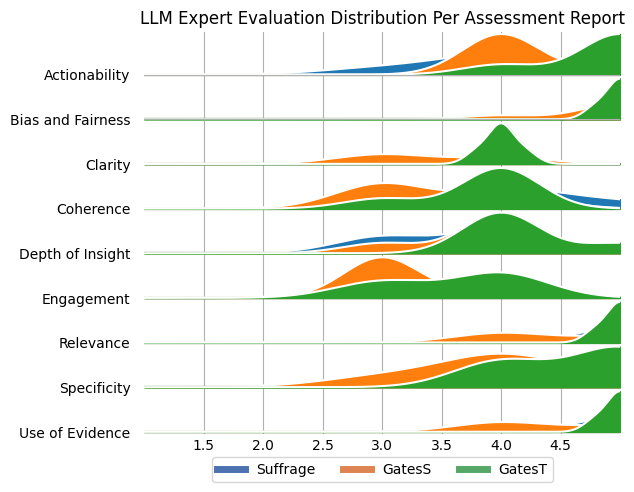

In [7]:
# Within each of the assignment columns, include the list of values as a numpy array
new_dict = defaultdict(list)
for i in range(len(attributes)):
    for j in range(NUM_OF_TRIALS):
        new_dict['Rating Type'].append(attributes[i])
        for assignment_name in assignment_names:
            assignment_df = evals[evals['assignment'] == assignment_name]
            row = assignment_df[attributes[i]].iloc[j]
            new_dict[assignment_name].append(row)

new_df = pd.DataFrame(new_dict)

# If an assignment's attribute values are all the same, we need to add some noise to the values
for attribute in attributes:
    attribute_df = new_df[new_df['Rating Type'] == attribute]
    for assignment_name in assignment_names:
        assignment_series = attribute_df[assignment_name]
        if len(assignment_series.unique()) == 1:
            # assignment_series = assignment_series + np.random.normal(0, 0.025, len(assignment_series))
            # Add -0.1 and 0.1 to the first two values
            assignment_series.iloc[0] = assignment_series.iloc[0] - 0.2
            assignment_series.iloc[1] = assignment_series.iloc[1] + 0.2
            new_df.loc[attribute_df.index, assignment_name] = assignment_series

# Rename the attributes to be more readable

# Ridgeline plot of LLM evaluations
# new_df_only_suffjrage = new_df[['Suffrage', 'Rating Type']]
# print(new_df_only_suffrage.head(10))
fix, ax = joypy.joyplot(new_df, title="LLM Expert Evaluation Distribution Per Assessment Report", by='Rating Type', grid=True, linecolor="white", ylim='own', x_range=[1,5], overlap=0.1)

# Define colors for each assignment
colors = {'Suffrage': "#4C72B0", 'GatesS': "#DD8452", 'GatesT': "#55A868"}

# Create a custom legend using Line2D
legend_elements = [Line2D([0], [0], color=color, lw=5, label=label) for label, color in colors.items()]

# Add manual legend
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.04), ncol=len(colors))
# plt.tight_layout()
plt.savefig(EVAL_DIR / 'llm_evaluations_joyplot.png')
plt.show()

# sns.set_theme(style="white")
# g = sns.FacetGrid(new_df, row="Rating Type", aspect=9, height=1.2)
# g.map_dataframe(sns.kdeplot, x="Suffrage")

In [30]:
# Compute the average of the average ratings for each assignment
llm_averages = []
for name, group in evals.groupby('assignment'):
    average = group[attributes].mean()
    llm_averages.append(average)

# Create a dataframe of the averages
llm_averages_df = pd.DataFrame(llm_averages)
# print(llm_averages_df)

# TODO: For now, create a fake human evaluation dataframe by subtracting 1 from the LLM averages
# Create a dataframe of the human evaluations
human_averages_df = llm_averages_df.copy()
human_averages_df[attributes] = human_averages_df[attributes] - 0.25
# print(human_averages_df)

# Merge the LLM and human averages
llm_averages_df['Evaluator'] = 'LLM'
human_averages_df['Evaluator'] = 'Human'
merged_df = pd.concat([llm_averages_df, human_averages_df], ignore_index=True)

# Convert to long format (columns=['Rating Type', 'Rating', 'Type'])
merged_df = pd.melt(merged_df, id_vars=['Evaluator'], value_vars=attributes, var_name='Rating Type', value_name='Rating')
print(merged_df)

   Evaluator        Rating Type  Rating
0        LLM            Clarity    3.40
1        LLM            Clarity    4.00
2        LLM            Clarity    4.00
3      Human            Clarity    3.15
4      Human            Clarity    3.75
5      Human            Clarity    3.75
6        LLM          Relevance    4.40
7        LLM          Relevance    5.00
8        LLM          Relevance    4.80
9      Human          Relevance    4.15
10     Human          Relevance    4.75
11     Human          Relevance    4.55
12       LLM          Coherence    3.40
13       LLM          Coherence    3.80
14       LLM          Coherence    4.00
15     Human          Coherence    3.15
16     Human          Coherence    3.55
17     Human          Coherence    3.75
18       LLM      Actionability    4.20
19       LLM      Actionability    4.80
20       LLM      Actionability    4.00
21     Human      Actionability    3.95
22     Human      Actionability    4.55
23     Human      Actionability    3.75


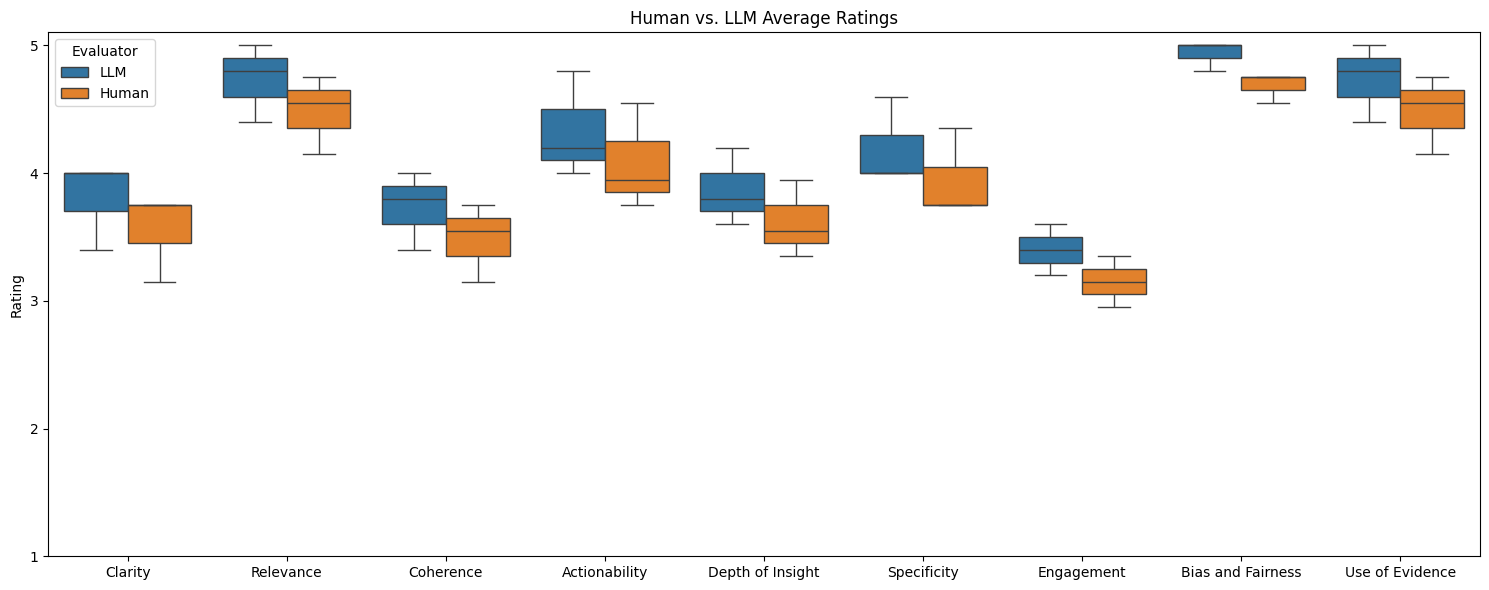

In [40]:
# %Boxplot Chart (Human vs. LLM Average Ratings)	
# Highlights differences between LLM and human scores	
# X-axis: Assignments, Y-axis: Likert Scores (1-5)

# Make the figure wider
plt.figure(figsize=(15, 6))
sns.boxplot(merged_df, x='Rating Type', y='Rating', hue='Evaluator')

# Make the range [1, 5] with 1 tick intervals
plt.yticks(np.arange(1, 5.1, 1))

# Pretty up the plot
plt.title('Human vs. LLM Average Ratings')
plt.xlabel('')
plt.ylabel('Rating')
# plt.legend(title='Evaluator', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Save the plot
plt.tight_layout()
plt.savefig(EVAL_DIR / 'human_vs_llm_ratings_boxplot.png')
plt.show()

In [ ]:
# %Scatter Plot (LLM vs. Human Agreement)	
# Shows correlation between LLM and human ratings	
# X-axis: LLM Mean Score, Y-axis: Human Score, Trendline

In [ ]:
# %Heatmap (Assignment-wise Ratings)	
# Visualizes assignment performance across different criteria	
# Rows: Assignments, Columns: Clarity, Relevance, Actionability